# Comparison between the original B3DB and current work
In this section we provide quantitative analysis of the records and identifiers present in the original and this work. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from molfeat.trans import FPVecTransformer
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px
from matplotlib_venn import venn2

from utils import smiles_to_fingerprint_tuple

[07:04:57] Initializing Normalizer


In [2]:
df_b3db_kc = pd.read_csv("dataset_intermediaries/03_b3db_kc_raw.tsv", sep="\t")
df_b3db = pd.read_csv("../data/B3DB/B3DB/B3DB_classification.tsv", sep="\t")
df_chembl_molecule_properties = pd.read_csv("../data/ChEMBL/chembl_molecule_properties.csv.gz", low_memory=False)
_s_chembl_inchi = set(df_chembl_molecule_properties.standard_inchi)
df_b3db["inchi_in_chembl"] = df_b3db.Inchi.apply(lambda x: x in _s_chembl_inchi)
df_b3db_kc["inchi_in_chembl"] = df_b3db_kc.inchi.apply(lambda x: x in _s_chembl_inchi)

In [3]:
# In the original dataset, there are 4037 unique Morgan fingerprints. This method produces 3729 unique ones. Since Morgan fingerprints represent 2D properties, they are not suitable of normalisation due to missing stereochemistry information. 
# Manual inspection of some of 1482 non-unique fingerprints (e.g. {643833, 638186, 10900}, {13676001, 21786, 11805068}) revealed shared structure but different stereochemistry.

df_b3db["fingerprint"]= df_b3db.SMILES.apply(smiles_to_fingerprint_tuple)
df_b3db_kc["fingerprint"] = df_b3db_kc.smiles.apply(smiles_to_fingerprint_tuple)

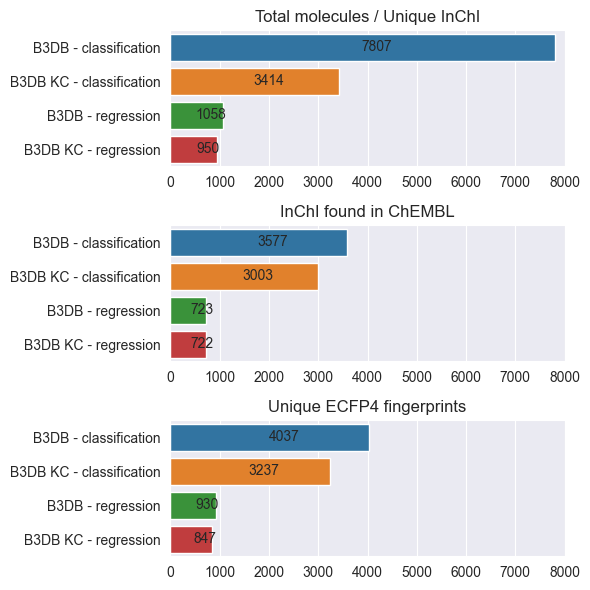

In [4]:
# fig, axs = plt.subplots(5, 1, figsize=[6, 8])
fig, axs = plt.subplots(3, 1, figsize=[6, 6])
def _plot_count(name, b3db_val, b3db_val_reg, b3db_kc_val, b3db_kc_val_reg, ax):
    sns.barplot(pd.DataFrame({
        "B3DB - classification": [b3db_val],
        "B3DB KC - classification": [b3db_kc_val],
        "B3DB - regression": [b3db_val_reg],
        "B3DB KC - regression": [b3db_kc_val_reg]}),
        orient="h", ax=ax
    )
    ax.set_title(name)
    ax.set_xlim(0, 8000)
    for bars in ax.containers:
        ax.bar_label(bars, padding=10, label_type="center")

df_b3db_reg = df_b3db[pd.notna(df_b3db.logBB)]
df_b3db_kc_reg = df_b3db_kc[pd.notna(df_b3db_kc.logBB)]    


_plot_count("Total molecules / Unique InChI", df_b3db.Inchi.nunique(), df_b3db_reg.Inchi.nunique(), df_b3db_kc.inchi.nunique(), df_b3db_kc_reg.inchi.nunique(), axs[0])
_plot_count("InChI found in ChEMBL", df_b3db.inchi_in_chembl.sum(), df_b3db_reg.inchi_in_chembl.sum(), df_b3db_kc.inchi_in_chembl.sum(), df_b3db_kc_reg.inchi_in_chembl.sum(), axs[1])
_plot_count("Unique ECFP4 fingerprints", df_b3db.fingerprint.nunique(), df_b3db_reg.fingerprint.nunique(), df_b3db_kc.fingerprint.nunique(), df_b3db_kc_reg.fingerprint.nunique(), axs[2])

plt.tight_layout()

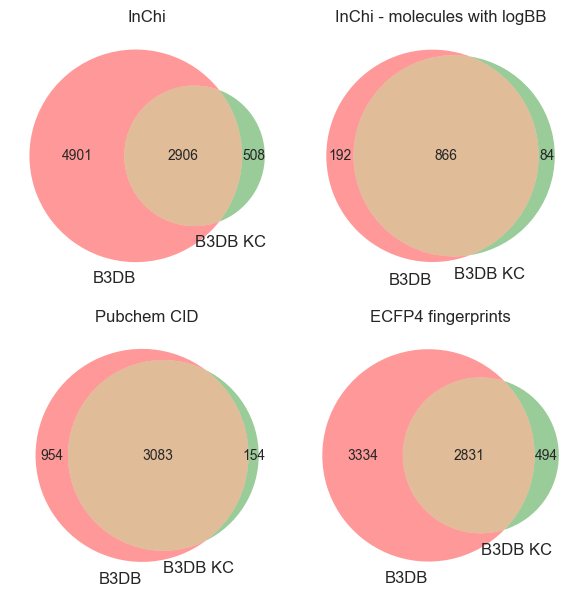

In [5]:

#fig, axs = plt.subplots(4, 1, figsize=[5, 9])
fig, axs = plt.subplots( 2, 2, figsize=[6, 6])

def _plot_venn(name, b3db_unique, b3db_kc_unique, ax):
    venn2([b3db_unique, b3db_kc_unique], set_labels=["B3DB", "B3DB KC"], ax=ax)
    #sns.barplot(pd.DataFrame({"B3DB": [b3db_unique], "B3DB KC": [b3db_kc_unique]}), orient="h", ax=ax)
    ax.set_title(name)
        
#_plot_count("No. entries", len(df_b3db), len(df_b3db_kc),  axs[0])
_plot_venn("InChi", set(df_b3db.Inchi.unique()), set(df_b3db_kc.inchi.unique()), axs[0][0])
_plot_venn("InChi - molecules with logBB", set(df_b3db_reg.Inchi.unique()), set(df_b3db_kc_reg.inchi.unique()), axs[0][1])
_plot_venn("\nPubchem CID", set(df_b3db.fingerprint.unique()), set(df_b3db_kc.fingerprint.unique()), axs[1][0])
_plot_venn("\nECFP4 fingerprints", set(df_b3db.CID.unique()), set(df_b3db_kc.cid.unique()), axs[1][1])


#_plot_venn("Unique SMILES", set(df_b3db.SMILES.unique()), set(df_b3db_kc.smiles.unique()), axs[1])
# Our work uses upper case characters in IUPAC names - in the original work IUPAC names are lowercase (e.g. H character in CID 4021). 
#_plot_venn("Unique IUPAC name (lowercase)", set(df_b3db.IUPAC_name.apply(lambda x: x.lower() if type(x) == str else None ).unique()), set(df_b3db_kc.iupac_name.apply(lambda x: x.lower() if type(x) == str else None).unique()), axs[2]) 
#_plot_venn("Unique PubChem CID", set(df_b3db.CID.unique()), set(df_b3db_kc.cid.unique()), axs[3])

plt.tight_layout()

## TSNE mappping

In [6]:
transformer_2d = FPVecTransformer(kind='desc2D', dtype=float, n_jobs=16)

df_b3db_kc_desc_2d = pd.DataFrame(transformer_2d(df_b3db_kc.smiles), columns=transformer_2d.columns)

df_b3db_desc_2d = pd.DataFrame(transformer_2d(df_b3db.SMILES), columns=transformer_2d.columns)

In [12]:
d_of_i = list(df_b3db_desc_2d)
# We drop 8 descriptors containing Nan's
all_descriptors = np.vstack((df_b3db_kc_desc_2d[d_of_i].dropna(axis=1).to_numpy(), df_b3db_desc_2d[d_of_i].dropna(axis=1).to_numpy()))
labels = ["B3DB KC"] * len(df_b3db_kc) + ["B3DB"] * len(df_b3db)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_descriptors)

Text(0, 0.5, 't-SNE 2')

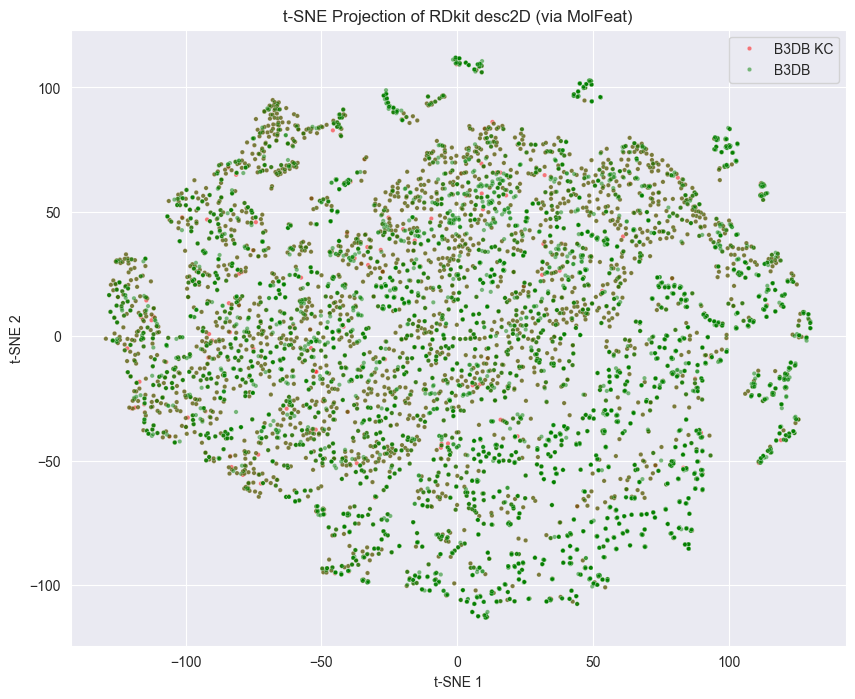

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(ax=ax, x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, alpha=0.5, s=10, palette={"B3DB": "green", "B3DB KC": "red"})
plt.title("t-SNE Projection of RDkit desc2D (via MolFeat)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

In [14]:
df = pd.DataFrame({
    't-SNE 1': tsne_results[:, 0],
    't-SNE 2': tsne_results[:, 1],
    'Label': labels,
    'SMILES': list(df_b3db_kc.smiles)+list(df_b3db.SMILES),
    'names': list(df_b3db_kc.names)+list(df_b3db.compound_name),
})

# Create the interactive scatter plot
fig = px.scatter(
    df, x='t-SNE 1', y='t-SNE 2', 
    color='Label', hover_data=['names'], 
    size_max=2, opacity=0.4
)
# Customize the layout
fig.update_layout(
    title='Interactive t-SNE Projection of Molecular Descriptors',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    width=1000,  # Adjust the figure width
    height=800,  # Adjust the figure height
    template="plotly_dark"  # Use dark theme
)

# Show the plot
fig.show()

In [10]:
df[df.names.apply(lambda x: "urea" in x.lower() if pd.notna(x) else False)]

,t-SNE 1,t-SNE 2,Label,SMILES,names
154,-49.595959,-19.084318,B3SB KC,CN1CC(=O)NC1=NC(=O)Nc1cccc(Cl)c1,Fenobam|3-(3-Chlorophenyl)-1-(1-Methyl-4-Oxo-5...
239,-118.235870,-11.021922,B3SB KC,CCCCNC(=S)Nc1ccccc1,1-Butyl-3-Phenylthiourea
615,8.793223,-8.124829,B3SB KC,O=C(Nc1cc(Cl)ccc1O)Nc1cc(C(F)(F)F)ccc1Cl,"Ns1738|Urea, N-(5-Chloro-2-Hydroxyphenyl)-N'-(..."
2776,-71.797585,82.592247,B3SB KC,[H]/N=C(/N)SC,S-Methylisothiourea|S-Methyl-Isothiourea|Carba...
2938,-74.717865,76.742447,B3SB KC,[H]/N=C(/N)SCCF,S-2Fluoroethylisothiourea|2-(2-Fluoro-Ethyl)-I...
3023,-75.813408,50.466541,B3SB KC,CNC(=O)NC(O)C(Cl)(Cl)Cl,Mecloralurea
3070,-77.695175,49.798981,B3SB KC,O=NN(CCCl)C(=O)NCCCl,Carmustine|Bcnu|Bis(Chloroethyl)Nitrosourea
3149,-99.896492,52.633888,B3SB KC,C/C=C(/CC)C(=O)NC(N)=O,Ectylurea
3398,-71.013168,90.189880,B3SB KC,NC(N)=O,Urea
3659,-71.730911,82.774223,B3DB,CSC(=N)N,s-methylisothiourea
